<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DM-44905: OR4 Alert Investigation Notebook</b> <br>
Contact author: Brianna Smart<br>
Last verified to run: -  05/27/2024<br>
LSST Science Piplines version: - Daily 2024_07_21 Large Container<br>
Container Size: Large <br># Clean Notebook

## Table of Contents

1. [Introduction](#Introduction)
2. [Conclusions](#Conclusions)
3. [Setup](#Setup)
4. [Load Data](#Load-Data)
5. [Plot OR4 Alerts](#Plot-OR4-Alerts)
6. [Plot Alerts Day 1](#Plot-Alerts-Day-1)
7. [Plot Alerts Day 2](#Plot-Alerts-Day-2)
8. [Plot Alerts Day 3](#Plot-Alerts-Day-3)
9. [OR4 Kafka pod recieved/transmited bytes rates](#OR4-Kafka-pod-recieved/transmited-bytes-rates)

## Introduction

OR4 was an excellent test to look at the current state of the pipelines and how alerts are entered into the alert stream. One of the pipeline requirements is for the alerts to enter the alert stream within 60-120 seconds after the end of the exposure. Using the OR4 data, we can interrogate how the pipelines currently perform. OR4 took place over 3 days and produced ~9.5 millions alerts (705 GB). Five downstream consumers (otherwise known as brokers but here reffered to as consumers to not cause confusion between the kafka broker pods and the consumers) connected to the alert stream and read from the alert stream log to test their performance.

## Conclusions

OR4 allowed us to look at the total time it takes for alerts to enter the alert stream after an exposure ends, as well as investigate parts of the stream to identify if they are adding to the total time. Additionally, we were able to look at the alert stream itself and kafka's performance. We were also able to provided and opportunity for our downstream consumers to access the alert stream and test their log access and reading capabilities.

We do not have the time of the exposure readout recorded in the alerts, however we do have the midpoint_tai, which gives the midpoint of the exposure. Comparing the midpoint to the log entry time allows as a somewhat accurate representation of the length of time that the pipelines take to deliver alerts to the alert stream. We saw delays between 5.5-7.5 minutes on average, with some delays taking up to 54 minutes. The larger delays appear to have been connected with pod-allocation issues and slowdowns in specific tasks in the pipeline, however we do not have exact numbers on these. Log outputs for slow components of the pipeline are being added in future releases for debugging. 

Additionally, we investigated if there was a significant delay in log ingestion times between when the kafka producer is called and when the alert is ingested into the alert stream. We found a delay ranging from 0-1000 milliseconds, or 0-1 seconds. On average, the delay was ~1 millisecond, and this is negligible and not a major factor in the delay between exposure readout and log ingestion. 

We also used OR4 to investigate the ingestion rate of the alerts, or how many alerts per minute arrived in the log. We found it ranged from 5k-7.5k alerts per minute. The log which was written to disk did not record the size of the alert, so we can only make assumptions based on the average alert packet size of 99 kB. This is an average of ~496-695 Mb per second. This will likely not be a representative rate of # of alerts once alert packet sizes begin to grow. 

We had several downstream consumers connect and read from the alert stream log. Alerce, Fink, Anteres, Lasair, and PittGoogle all connected succesfully. Alerce, Fink, and Lasair all were able to demonstrate their ability to read the log out while alerts are ingested with minimal lag. Alerce and Fink had an average lag ~1.2k alerts, and were able to drop to zero lag, keeping up with the alerts in the log quickly. Lasair had a lag ~1.5k, and only dropped to zero during times were fewer alerts were entering the log. This was all monitored via Kowl and thus we do not have robust numbers monitoring consumer lag. We have noted the need for a dashboard which would let us chart consumer lag actively instead of monitoring it in one off snapshots.

A seperate investigation of the network traffic recieved per pod shows a maximum of 7.84 MiB/s, and a maximum transmitted rate of 39.8 MiB/s. OR4 demonstrated that the alert stream is currently able to quickly handle recieving and sending alerts to consumers with minimal delay at current data rates. Additional tools/monitoring should be created for future monitoring and to help downstream consumers.

In [30]:
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from IPython.display import display

In [21]:
def plot_metrics(time_mjdtai,time_log, time_production, time_diff, time_min, time_max, days = 1):

    # Change the time arrays unto numpy arrays. 
    
    time_mjdtai=np.array(time_mjdtai)
    time_diff=np.array(time_diff)
    time_production=np.array(time_production)
    time_log=np.array(time_log)

    # Set the timeframe to look at
    timeframe = np.where((time_mjdtai > time_min) & (time_mjdtai < time_max))[0]
    
    log=Time(time_log/1000.0, format="unix_tai")
    produce=Time(time_production/1000.0, format="unix_tai")
    mjd=Time(time_mjdtai, format="mjd")
    max_mjd=Time(time_max, format="mjd")
    min_mjd=Time(time_min, format="mjd")
    counts, bin_edges = np.histogram(log.mjd[timeframe], bins=int((max_mjd.unix_tai-min_mjd.unix_tai)/60.0))
    bins=int((max_mjd.unix_tai-min_mjd.unix_tai)/60.0)
    print(bins)

    log_delay=(log.unix-mjd.unix)/60.0

    print("Average log delay in minutes",  np.average(log_delay[timeframe]))
    print("Max delay in minutes:",  np.max(log_delay[timeframe]))
    print("Min delay in minutes: ",  np.min(log_delay[timeframe]))
    print("Average Log/Producer Delay in milliseconds", np.average(time_diff[timeframe]))


    plt.figure(figsize=(8, 6))  # Adjust figsize as needed
    plt.scatter(time_mjdtai[timeframe], time_diff[timeframe], s=0.2, facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.8)
    plt.title('Production/Log Delta vs MJD-TAI')
    plt.xlabel('MJD-TAI')
    plt.ylabel('Difference in ms')

    plt.figure(figsize=(8, 6))  # Create another figure for the second scatter plot
    plt.scatter(time_mjdtai[timeframe], log_delay[timeframe], s=.2, facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.8)
    plt.title('Log Time - Midpoint MJD-TAI (minutes) vs MJD-TAI (' + str(time_min) + ' - ' + str(time_max) + ')')
    plt.xlabel('MJD-TAI')
    plt.ylabel('Log Time - Midpoint MJD-TAI (minutes)')

    plt.figure(figsize=(8, 6))  # Create another figure for the second scatter plot
    plt.hist(time_mjdtai[timeframe], bins=bins*days,range=[time_min, time_max])
    plt.title('Alerts per minute')
    plt.xlabel('1 minute bins')
    plt.ylabel('# of Alerts')

    # These last two will be overpolotted onto each other. The blue is the midpoint tai, so the rate of alerts produced, and the
    # overlaid black is the log ingestion time.
    result = plt.hist(log.mjd[timeframe], bins=bins, color='c', edgecolor='k', alpha=0.65,range=[time_min, time_max])

    return counts, bin_edges, result

## Load Data

The data was read from the alert stream and into a text file after OR4 was complete. It contains some pre-OR4 data and thus the time in MJD was needed to only examine alerts from OR4.

In [5]:
filename = 'stream_output_jun_27.txt'
with open(filename, 'r') as file:
    # Initialize empty arrays for each column
    time_mjdtai = []
    time_log = []
    time_production = []
    time_diff = []

    # Read each line in the file
    for line in file:
        # Split the line into columns
        parts = line.strip().split(', ')
        if len(parts) >= 5:
            col1 = float(parts[0])
            col2 = int(parts[2][:-1])    
            col3 = int(parts[3][2:-1])  
            col4 = int(parts[4])   
    
            # Append each column to its respective array
            time_mjdtai.append(col1)
            time_log.append(col2)
            time_production.append(col3)
            time_diff.append(col4)

The oldest mjdtai times are from ap_verify. The correct timeframe for OR4 is 60487-60489.

In [6]:
print(max(time_mjdtai))
print(min(time_mjdtai))

60489.44601953126
59583.12233422338


## Plot OR4 Alerts

#### Here we make plots for all of the OR4 alert data.

The first set of alerts shows trhe difference in time between the production vs the log entry time vs the production timestamp. We can see that in general, most of the alerts have less than a millisecond delay between reaching the producer and then reaching the log. The average delay is 1.11 milliseconds, with few taking over 1 second.

The second chart is the delay between the midpoint mjd-tai and when the alert finally arrives in the log. The difference has been scaled to minutes. The average time is ~6.5 minutes, but can be as high as 54 minutes. This delay appears to have a number of factors in the pipelines, including delays in pod assignments and long task times. 

The last plot shows the number of alerts created per minute in blue and overlays the number of alerts recieved per minute in black. The blue

4320
Average log delay in ms 6.519663842490828
Average producer delay 6.51964335623848
Max delay: 51.782683257261915
Min delay:  1.2237250606218975
1.229175134893773


(array([1526, 2384, 8094, ..., 1125, 1234, 1363]),
 array([60487.05835138, 60487.05890519, 60487.059459  , ...,
        60489.44971188, 60489.45026569, 60489.4508195 ]),
 (array([0., 0., 0., ..., 0., 0., 0.]),
  array([60487.        , 60487.00069444, 60487.00138889, ...,
         60489.99861111, 60489.99930556, 60490.        ]),
  <BarContainer object of 4320 artists>))

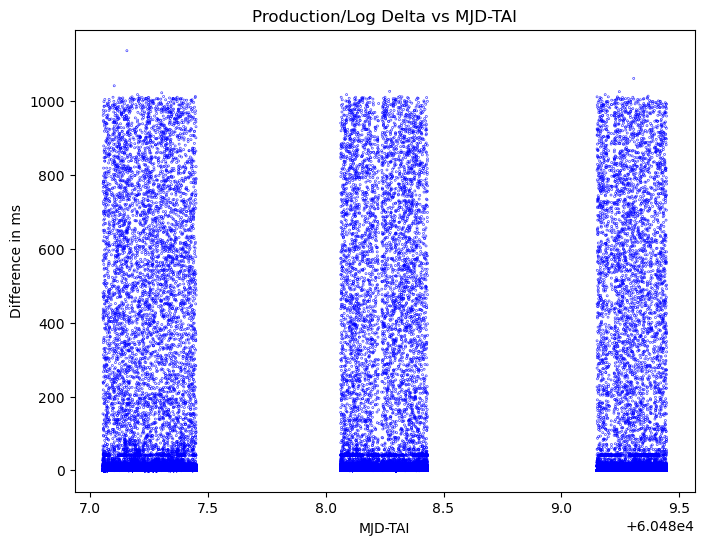

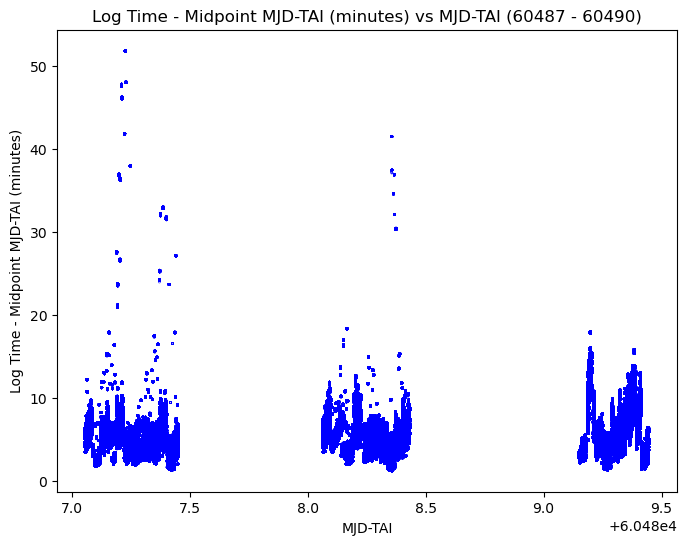

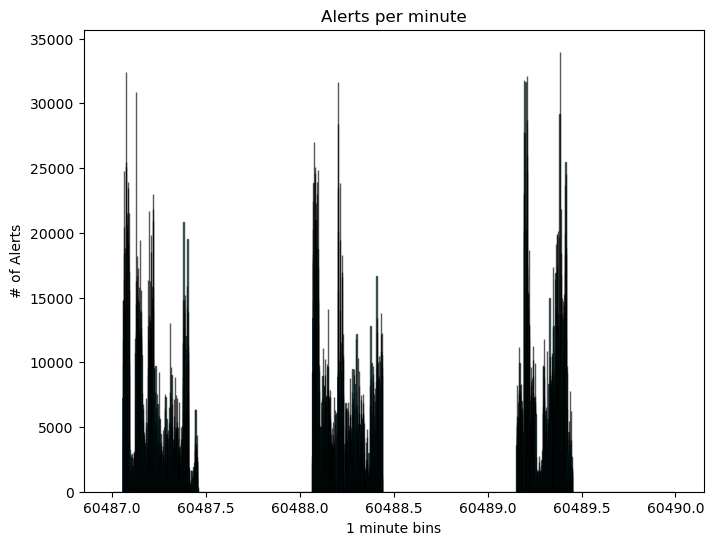

In [20]:
plot_metrics(time_mjdtai,time_log, time_production, time_diff, 60487, 60490, days = 3)

In [14]:
time_mjdtai=np.array(time_mjdtai)
time_diff=np.array(time_diff)
time_production=np.array(time_production)
time_log=np.array(time_log)

## Plot Alerts Day 1

Day 1 of OR4 had an average delay of 6 minutes between observation and alerts being entered into the log. An average of 5820 alerts entered the log per minute, with a maximum ingestion rate of 34,402 alerts in one minute. Assuming an average packet size of 99 kb, this gives us a data ingestion rate of 578 Mb per minute. The maximum delay in alert arrival time was over 40 minutes.

1440
Average log delay in minutes 6.04038042330619
Max delay in minutes: 41.4469168027242
Min delay in minutes:  1.2237250606218975
Average Log/Producer Delay in milliseconds 1.2918703993305822
2146.14375
31631.0
2146.14375


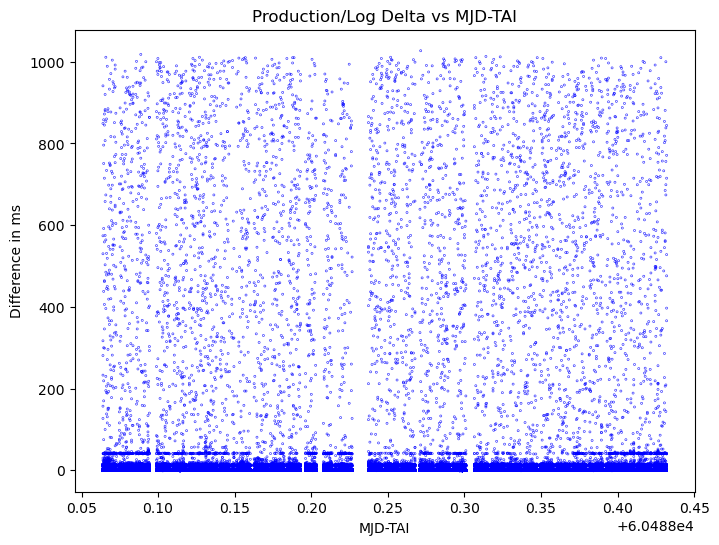

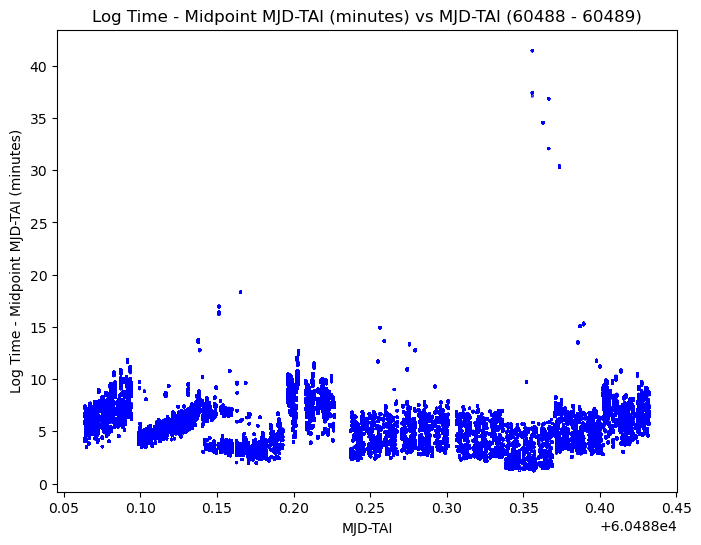

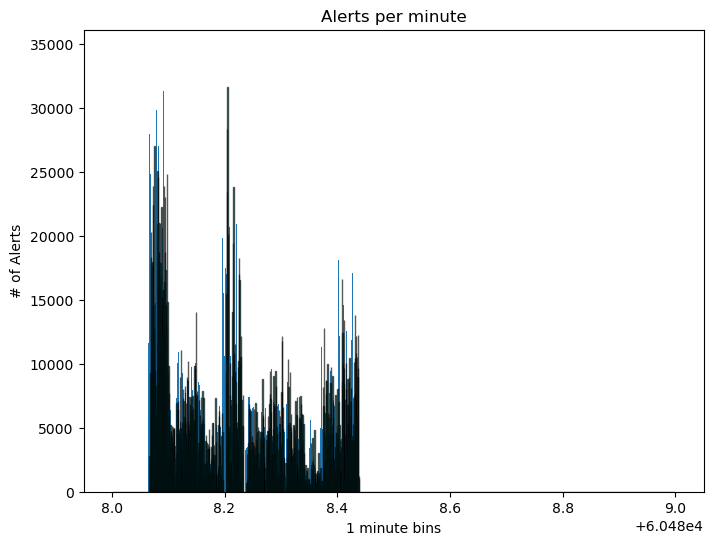

In [22]:
count, bins, result_60488 = plot_metrics(time_mjdtai,time_log, time_production, time_diff, 60488, 60489)
print(np.average(count))
print(max(result_60488[0]))
print(np.average(result_60488[0]))

In [16]:
np.average(result_60488[0][92:623])
np.min(result_60488[0][92:623])

0.0

In [17]:
np.min(result_60488[0][np.nonzero(result_60488[0])])

9.0

## Plot Alerts Day 2

On day two, we saw two bursts of late alerts, delayed as much as ~50 minutes and an average delay of 5.86 minutes from midpoint tai to log ingestion time. The average delay between the producer and the log ingestion time is 1.23 milliseconds, and the average alerts per minute ingestion rate in the log is 5821 alerts per minute. The second day also suffered several pod issues, likely resulting in the longest delays. 

1440
Average log delay in minutes 5.866923639966359
Max delay in minutes: 51.782683257261915
Min delay in minutes:  1.2628584027290344
Average Log/Producer Delay in milliseconds 1.2520584695579713
32415.0


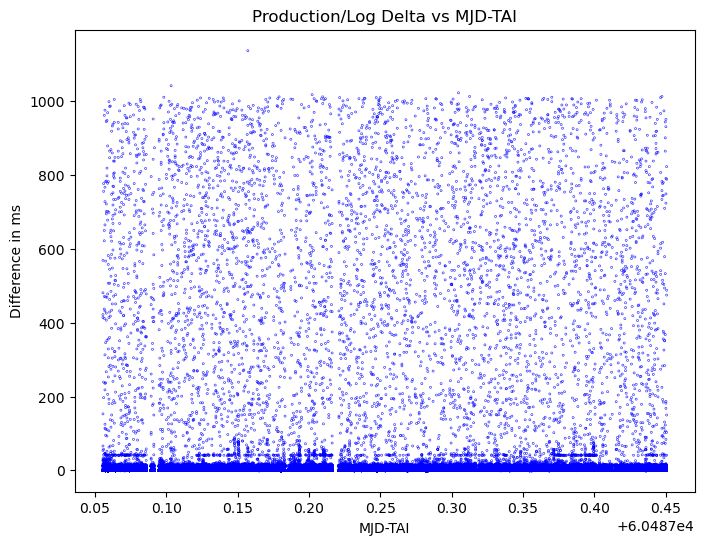

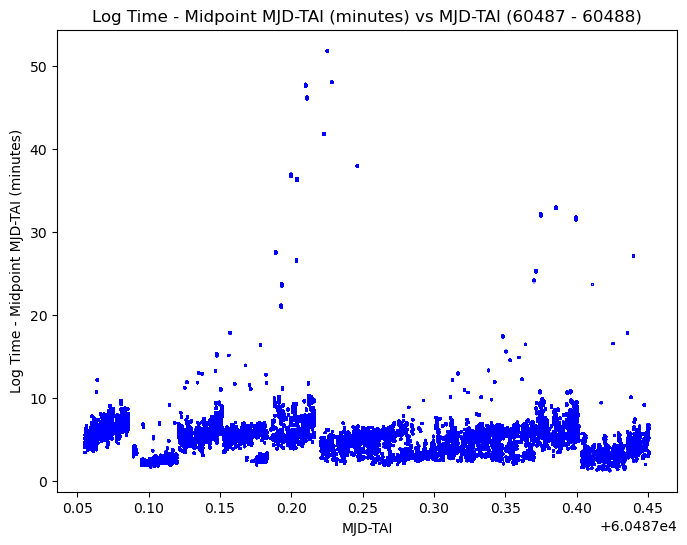

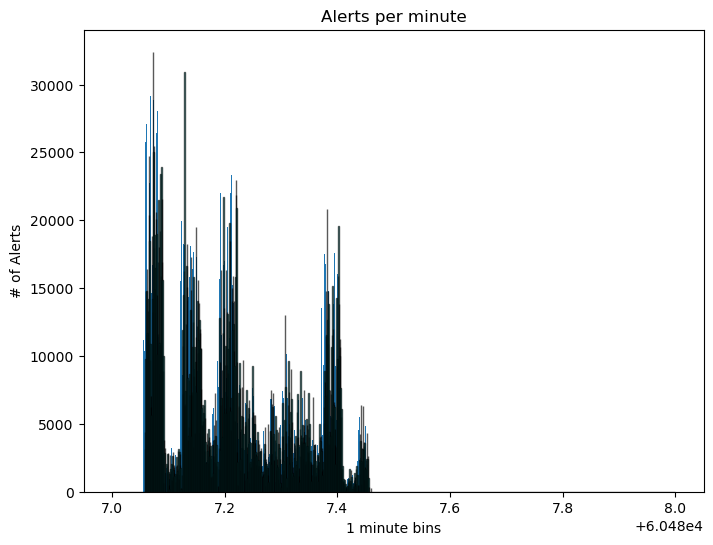

In [51]:
count, bin_edges, result_60487 = plot_metrics(time_mjdtai,time_log, time_production, time_diff, 60487, 60488)
print(max(result_60487[0]))

In [52]:
np.average(result_60487[0][79:649])

5821.429824561404

### Plot Alerts Day 3

For day three, we saw a significant decrease in the maximum delay between the midpoint time and the log entry time. However, the average time between the midpoint and the log ingestion time incread to 7.7 minutes. The average alerts per minute increased to 7081 alerts per minute.  The last day had the least pod issues, and thus the time between the observation midpoint and the log ingestion time is the most representative of the current capabilities of the pipelines. The average delay between producer time and log entry time was 1.14 milliseconds.

1440
7.724106242231754
7.724087237868961
1.1402617128361485


33985.0

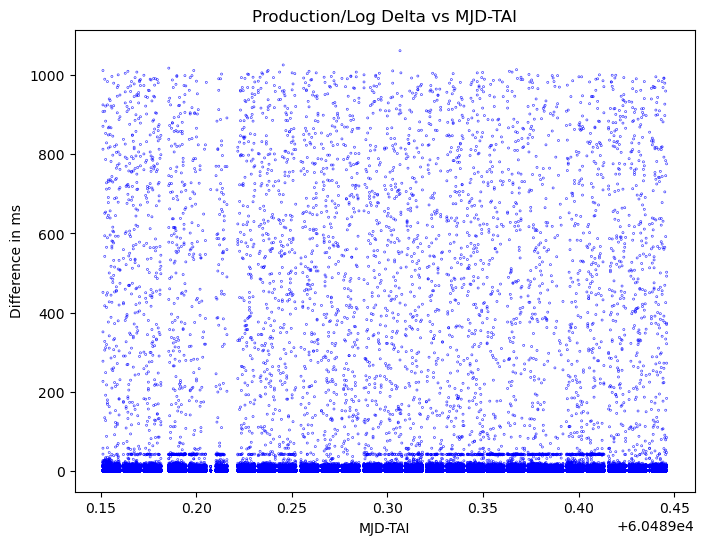

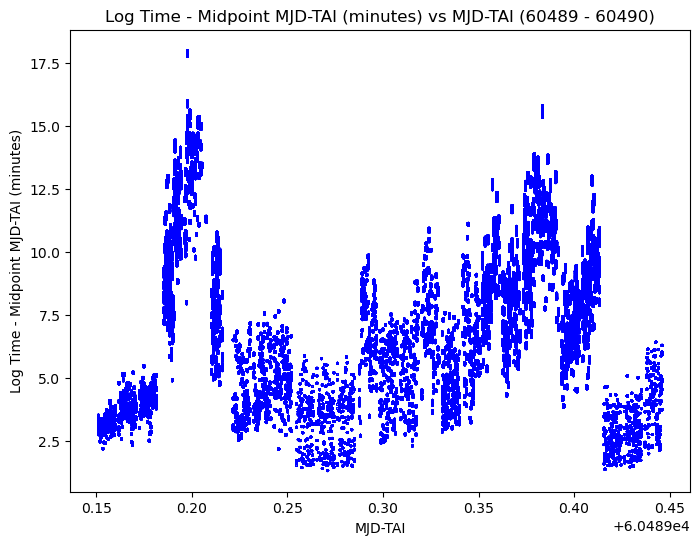

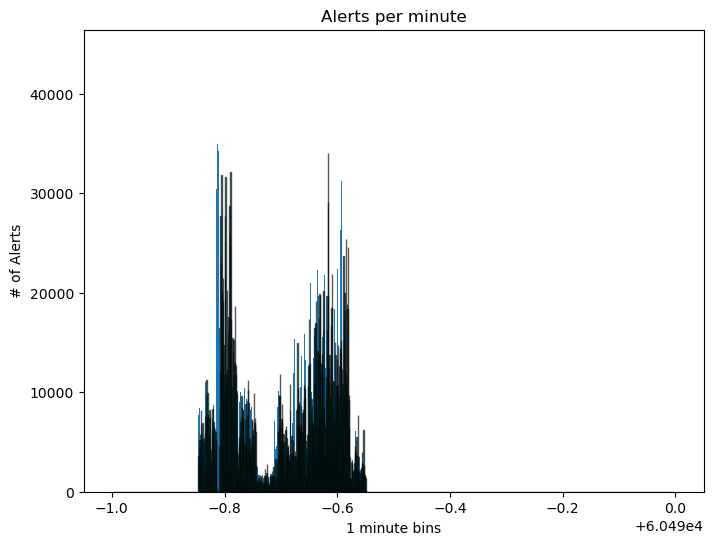

In [9]:
counts, bin_edges , results_60489= plot_metrics(time_mjdtai,time_log, time_production, time_diff, 60489, 60490)
max(results_60489[0])

In [25]:
np.average(results_60489[0][221:650])

7081.018648018648

In [24]:
results_60489[0][221:650]

array([ 3587.,  3295.,  5153.,  5825.,  4352.,  4192.,  5021.,  8235.,
        5306.,  5757.,  6906.,  5309.,  3284.,  4888.,   119.,  1693.,
        1403.,  5945.,  7482.,  2657., 11205.,  7819.,  7605.,  9958.,
        7712.,  7294.,  5717.,  4908.,  8223.,  7458.,     0.,  3228.,
        1923.,  2668.,  5419.,  6155.,  8322.,  6619.,  7018.,  6473.,
        2204.,  4125.,  6326.,  6013.,  5025.,  5269.,   295.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,  4574.,  8292.,
       27748., 23109., 22810., 31785., 20041., 19157., 21421.,  2116.,
        1740., 11859., 14756., 27730., 10139., 31639.,  9282., 11805.,
       20305., 12372.,  7234.,  8436., 15876., 17526., 16707., 28743.,
       24689., 25984., 32119., 17313.,  2570., 10574.,  2978., 15438.,
       14077., 15241.,  8771., 11301., 12921., 18664.,  7562., 11817.,
       12777.,  9821.,  4070.,  1242.,     0.,  1461.,  2505.,  5004.,
        4478.,  5452.,  4878.,  7044.,  4692.,  7459.,  9598.,  8541.,
      

## OR4 Kafka pod recieved/transmited bytes rates

From the grafana dashboard for the alert stream, we were able to monitor the induvidual pods recievied/transmited bytes per second. There were a total of 6 alert broker pods, with pod 5 restarting part way through the test with no noticable disruptions. The recieved data seemed to be evenly streamed between pods, with no pod substantially outperforming another in terms of bytes recieved/transmitted. The maximum recieved data rate was 7.64 MiB/s, and the maximum data transmitted was 39.8 MiB/s. 

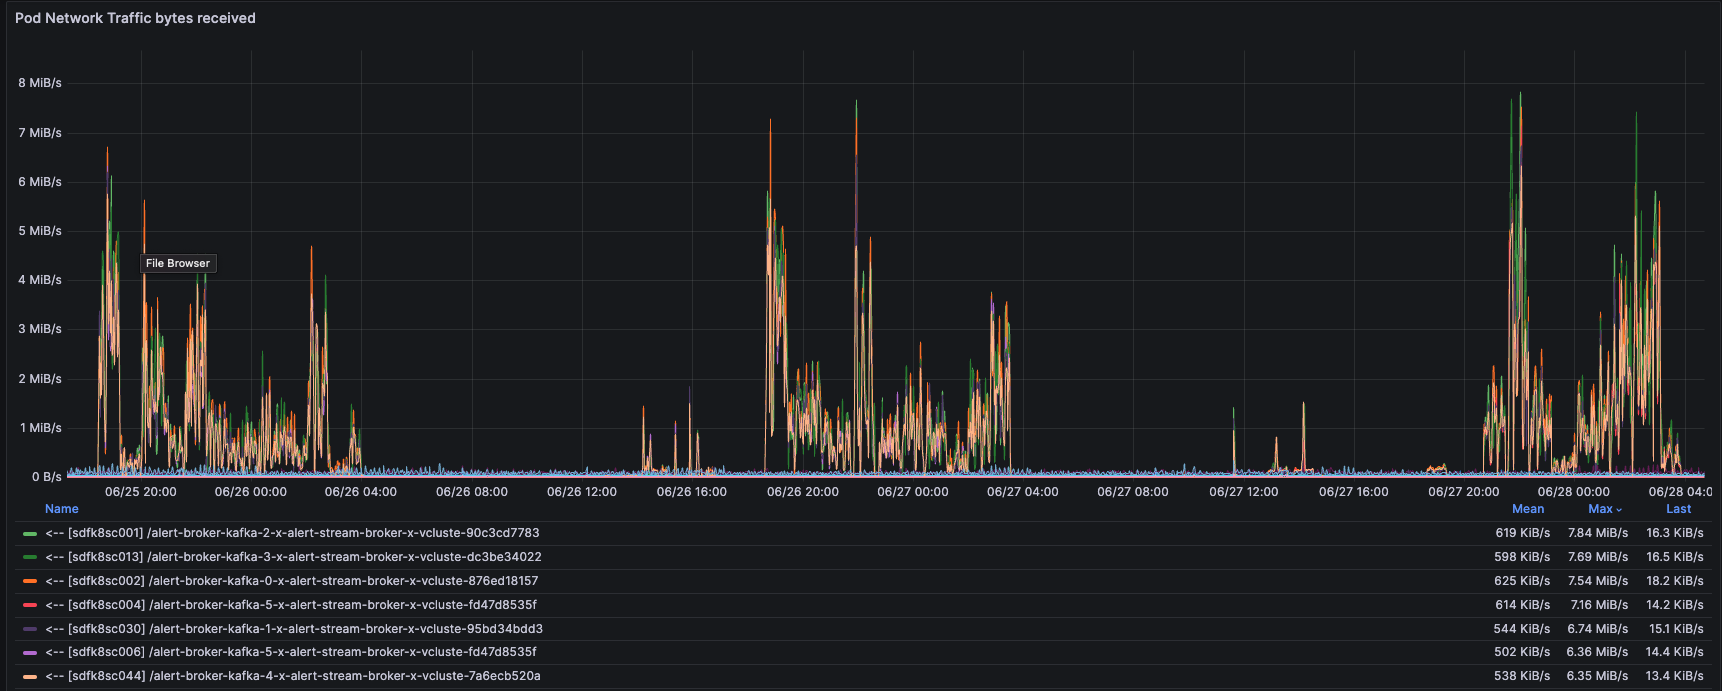

In [34]:
img = Image.open('./OR4BytesRecieved.png')
display(img)

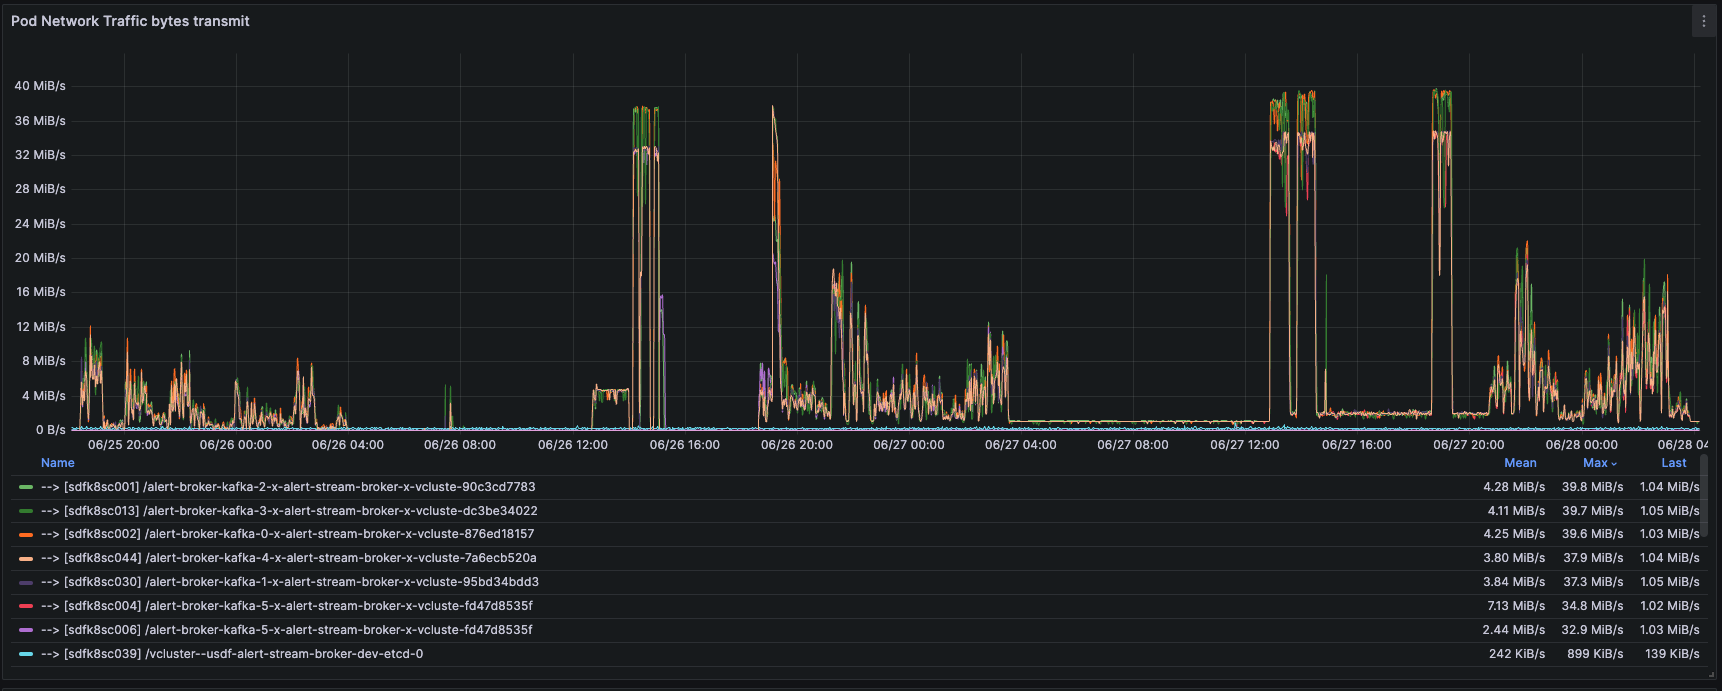

In [43]:
img = Image.open('./OR4BytesTransmitted.png')
display(img)

### Day 1

On day 1, from 18:30 to ~04:00, the recieved network recieved traffic at a mean rate of 1.00-1.19 MiB/s per pod. Data cam in bursts due to ongoing issues with pod distribution during processing. The maximum data rate was 5.88-6.73 MiB/s.

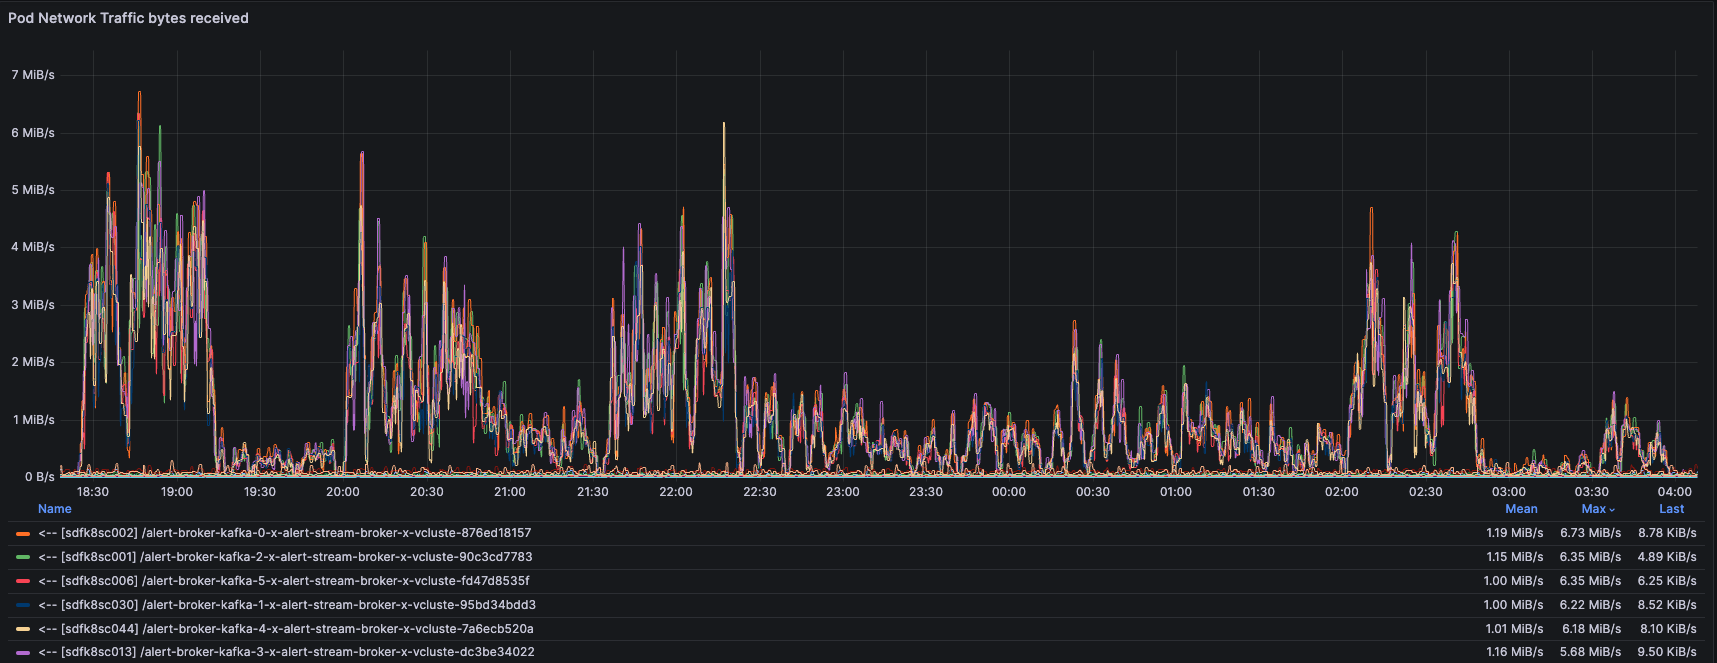

In [44]:
img = Image.open('./OR4Day1BytesRecieved.png')
display(img)

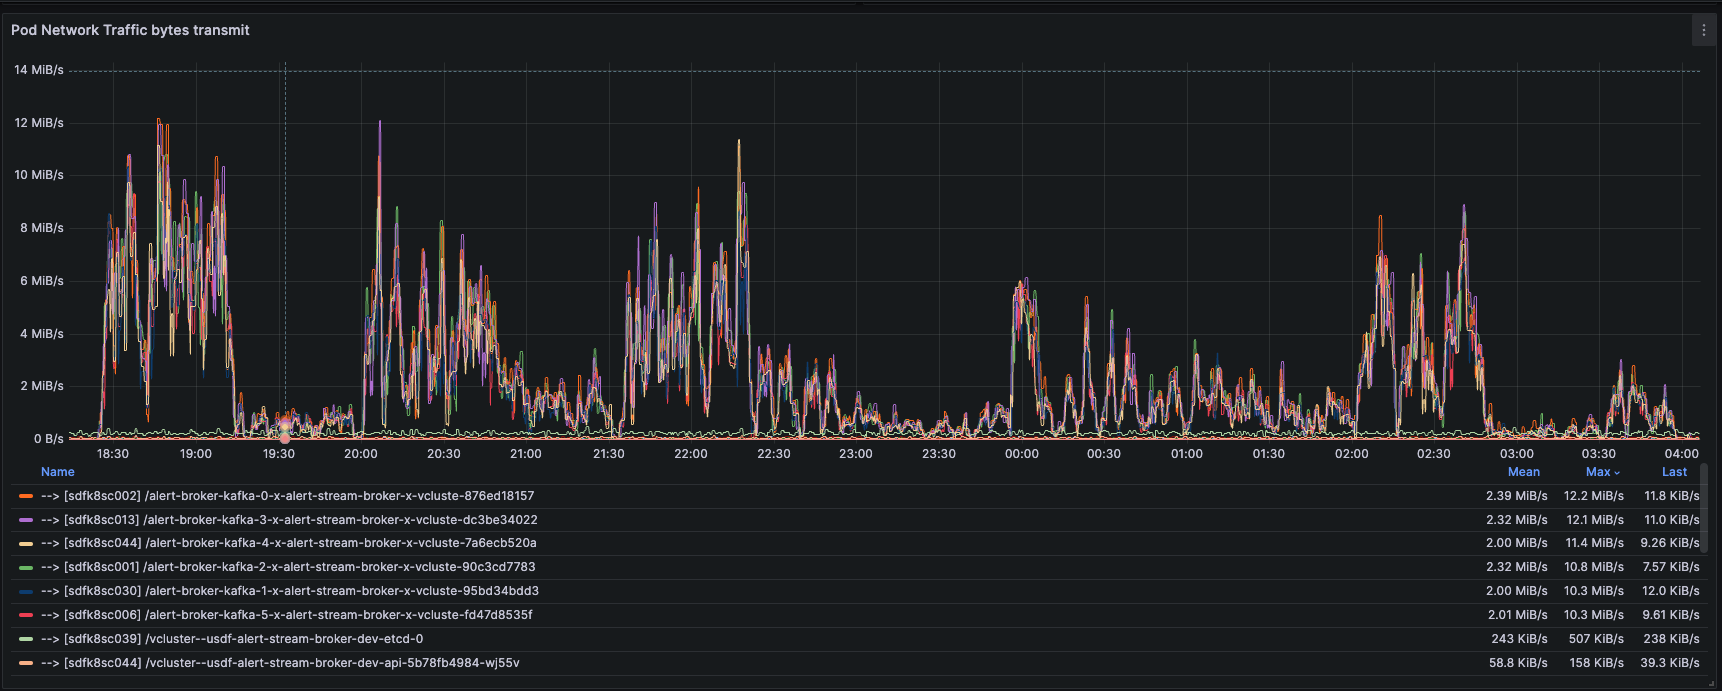

In [40]:
img = Image.open('./OR4Day1BytesTransmitted.png')
display(img)

### Day 2 

On day 2, data began arrive ~18:37, and was transmitted until ~03:50. During this time the mean data rate recieved was between 1.08-1.27 MiB/s. The maximum bute rate recieved was between 6.22-7.69 MiB/s. During Day2, several of the consumers were catching up in the log and/or restarting their read of the log. This meant that several consumers were reading the full log simultaniously. This resulted in maximum transmitted byte rates of 21.5 MiB/s and 37.9 MiB/s. 

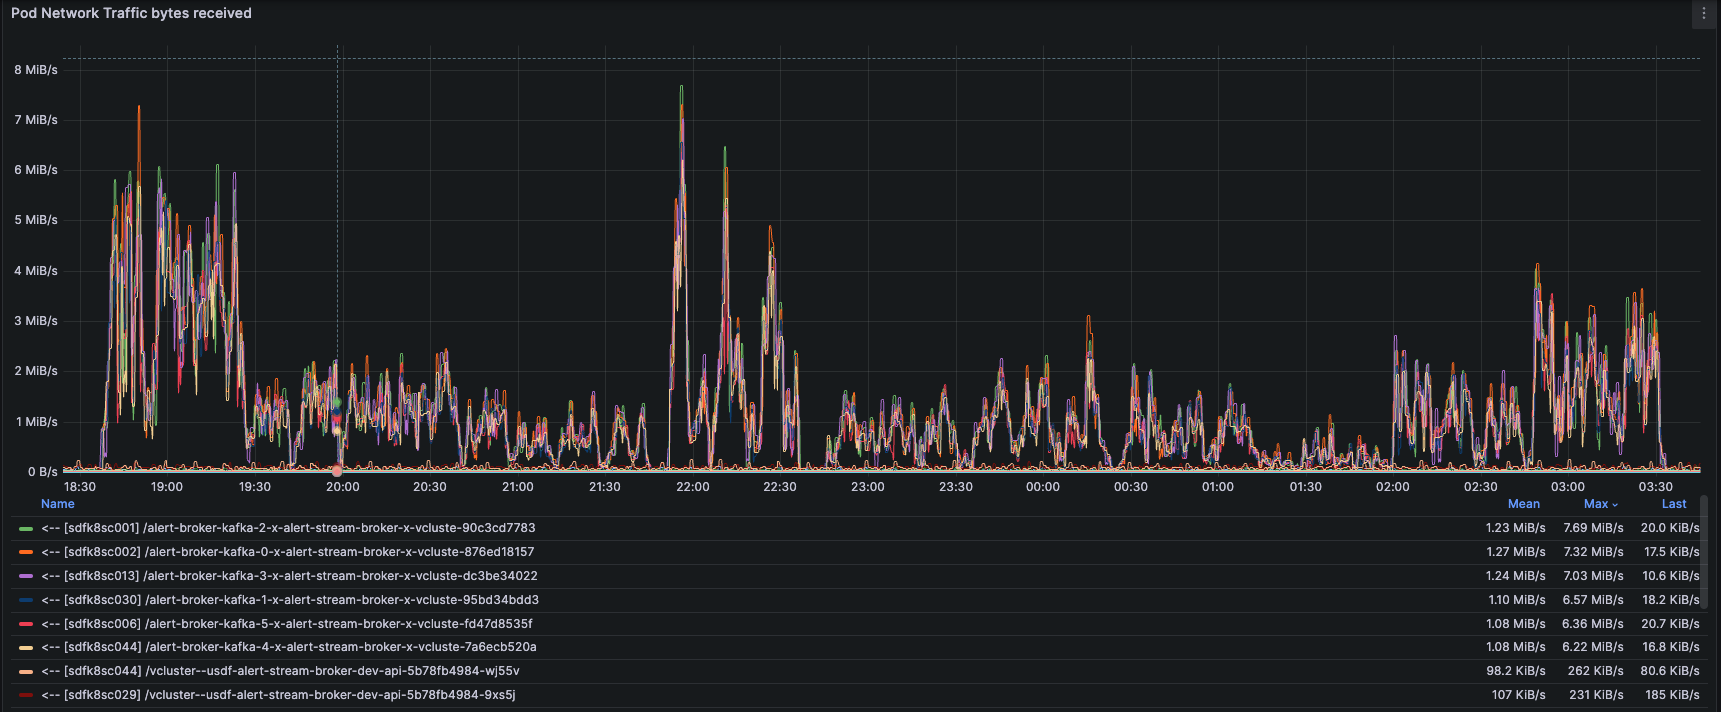

In [48]:
img = Image.open('./OR4Day2BytesRecieved.png')
display(img)

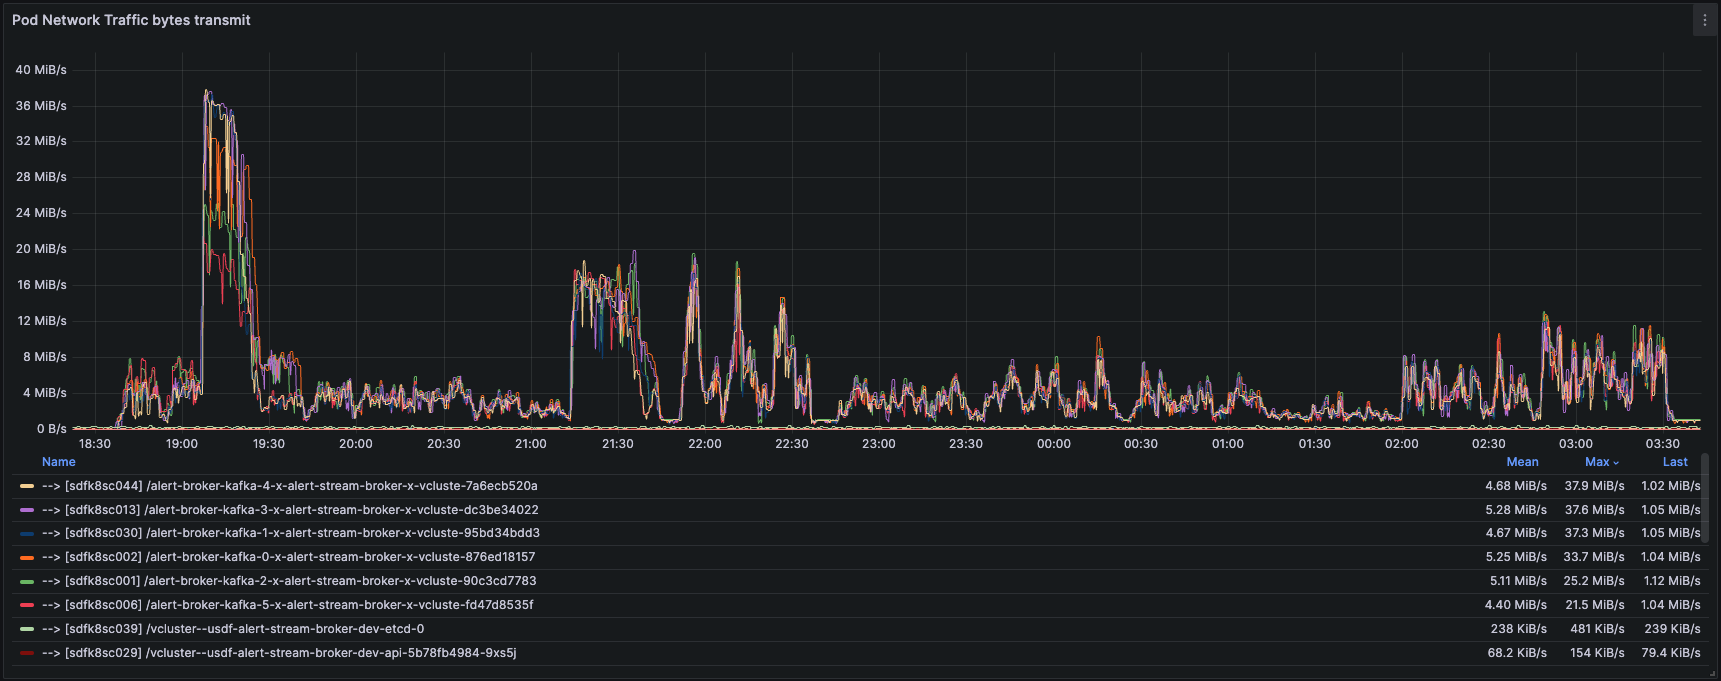

In [47]:
img = Image.open('./OR4Day2BytesTransmitted.png')
display(img)

### Day 3

On day 3, the maximum recieved byte rate was between 7.14 and 8.66 MiB/s.  The average rate was between 1.3 and 1.51 MiB/s. The bytes transmitted on the last day was lower, ranging between 19.8 MiB/s and 24 MiB/s for the maximum transmitted rate. However, on this day the consumers were starting at the beginning of the night already caught up with the log, and all active consumers were reading out the alerts as they were recieved in the alert stream. On night 3, the maximum lag for Alerce and Fink was 1.2k alerts, with the consumers often dropping to 0 lag thoughout the night. Lasair consistently lagged by 1.5-3.5k alerts and was thus constantly reading the log. Additionally, PittgGoogle was not reading from the log on the last night.

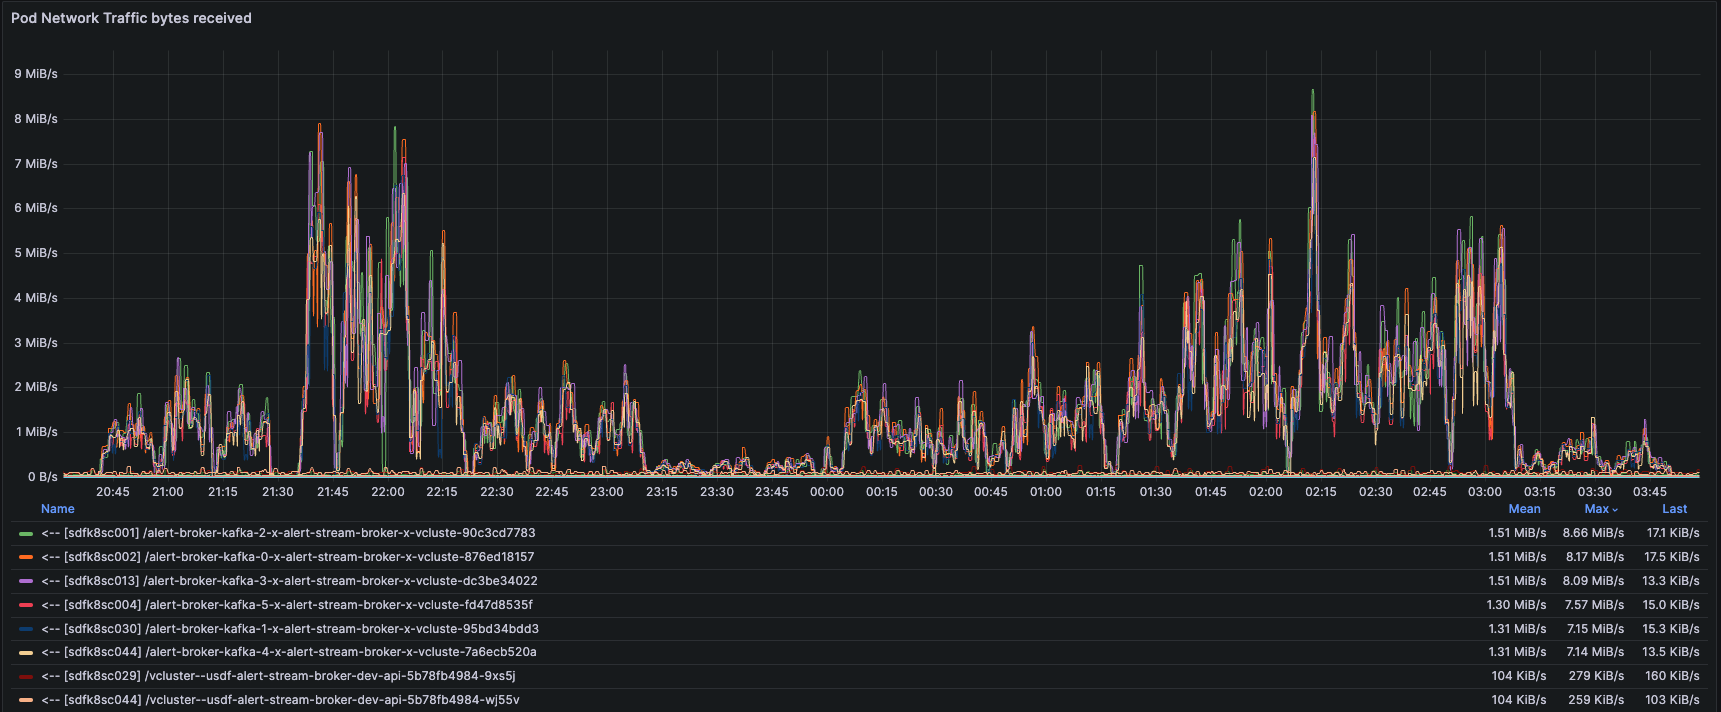

In [45]:
img = Image.open('./OR4Day3BytesRecieved.png')
display(img)

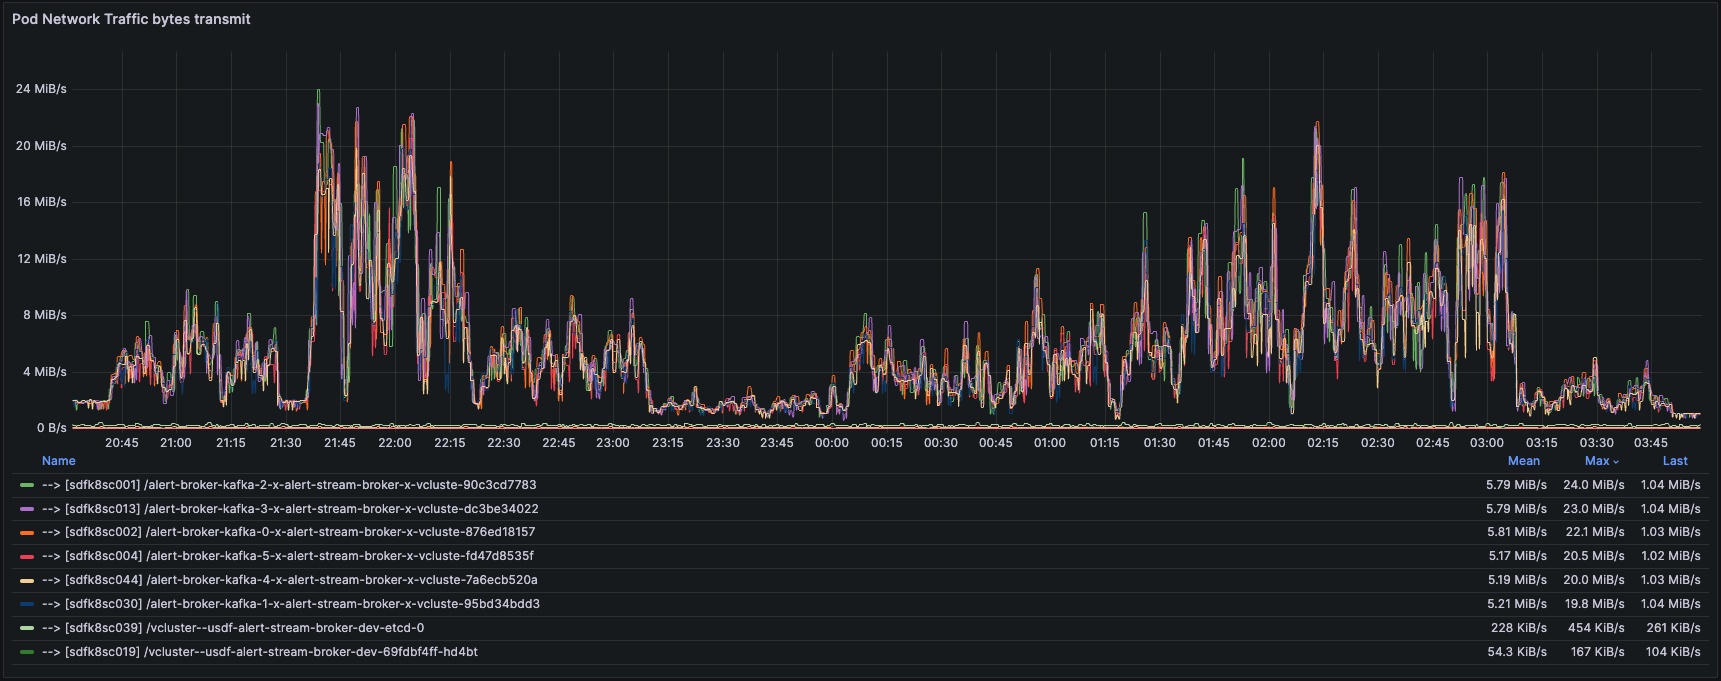

In [46]:
img = Image.open('./OR4Day3BytesTransmitted.png')
display(img)